In [113]:
# Libraries to be used
# !pip install darts
# !pip install gluonts[mxnet]

In [114]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
from itertools import islice
import mxnet as mx

In [115]:
from darts import TimeSeries
from darts.models import ExponentialSmoothing, AutoARIMA, Theta, NBEATSModel, LightGBMModel
from darts.metrics import mape, rmse
from darts.utils import utils

In [116]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.mx import DeepAREstimator, Trainer
from gluonts.evaluation import make_evaluation_predictions
from gluonts.evaluation import Evaluator

In [117]:
# Set seeds
mx.random.seed(7)
np.random.seed(7)

# Load the dataset

In [118]:
revenue_data = pd.read_excel('Revenue_clean.xlsx', index_col=0)

In [119]:
revenue_data[:5]

,Revenue,temperature,humidity,pressure,wind_speed
2018-01-01,3087464.68,3.240741,0.984444,979.111111,20.555556
2018-01-02,3087464.68,2.333333,0.980351,985.035088,13.543860
2018-01-03,3087464.68,1.923077,0.973077,979.807692,15.461538
2018-01-04,2770763.36,2.285714,0.928571,973.959184,24.040816
2018-01-05,2770763.36,2.290909,0.915818,975.309091,23.563636


<AxesSubplot:>

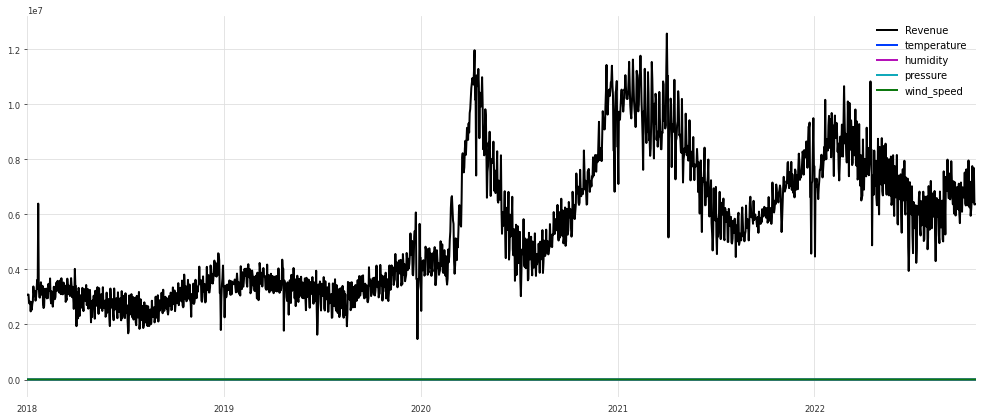

In [120]:
revenue_data.plot(linewidth=2, figsize=(17,7))

In [121]:
# A dataframe to store metrics
metrics_df = pd.DataFrame(columns = ["Model", "RMSE", "MAPE"])

# ExponentialSmoothing model (Darts library)

In [122]:
revenue_data_2 = revenue_data[['Revenue']]

In [123]:
revenue_data_2[:5]

,Revenue
2018-01-01,3087464.68
2018-01-02,3087464.68
2018-01-03,3087464.68
2018-01-04,2770763.36
2018-01-05,2770763.36


In [124]:
# Convert to a Timeseries
series = TimeSeries.from_dataframe(revenue_data_2)

In [125]:
model = ExponentialSmoothing(seasonal_periods=7)
train, val = series.split_after(pd.Timestamp("20220801"))
model.fit(train)
pred = model.predict(90)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


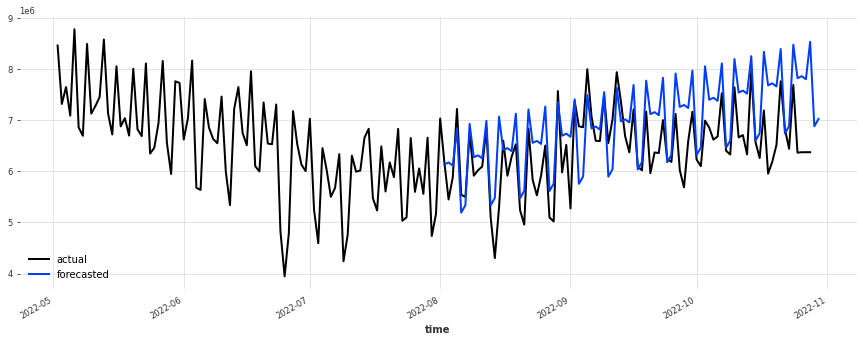

In [126]:
# plotting results
plt.figure(figsize=(15,5))
series[-180:].plot(label = "actual")
pred.plot(label = "forecasted") # validation data set
plt.legend()
plt.show()

In [127]:
metric = pd.DataFrame({'Model':['ExponentialSmoothing'],
        'RMSE':[int(rmse(val, pred))],
        'MAPE':[mape(val, pred) / 100.]})

metrics_df = pd.concat([metrics_df, metric])

# LightGBMModel model (DARTS library)

In [128]:
model = LightGBMModel(lags=12)
train, val = series.split_after(pd.Timestamp("20220801"))
model.fit(train)
pred = model.predict(90)


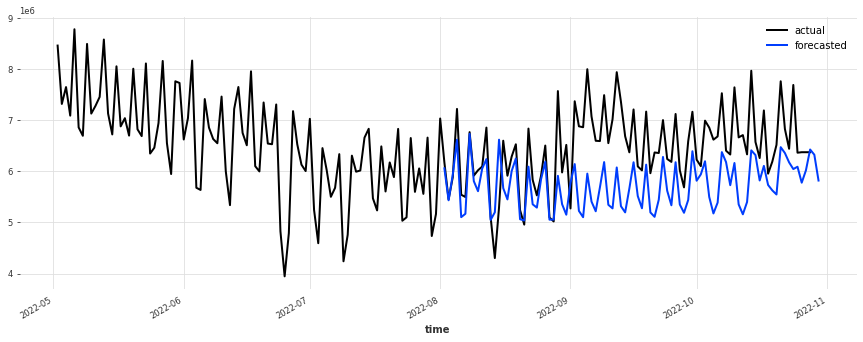

In [129]:
# plotting results
plt.figure(figsize=(15,5))
series[-180:].plot(label = "actual")
pred.plot(label = "forecasted") # validation data set
plt.legend()
plt.show()

In [130]:
metric = pd.DataFrame({'Model':['LightGBMModel'],
        'RMSE':[int(rmse(val, pred))],
        'MAPE':[mape(val, pred) / 100.]})

metrics_df = pd.concat([metrics_df, metric])

# NN model (DARTS library)

In [131]:
model = NBEATSModel(input_chunk_length=30, 
                    output_chunk_length=30, 
                    n_epochs = 10, 
                    random_state = 42,
                    force_reset=True,
    pl_trainer_kwargs={
      "accelerator": "gpu",
      "devices": [0]
    },)
train, val = series.split_after(pd.Timestamp("20220801"))
model.fit(train, val_series=val, verbose=False)
pred = model.predict(n = 90, series = train)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


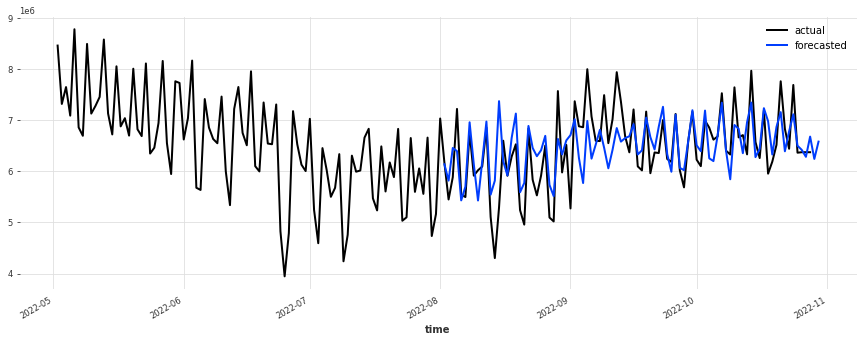

In [132]:
# plotting results
plt.figure(figsize=(15,5))
series[-180:].plot(label = "actual")
pred.plot(label = "forecasted") # validation data set
plt.legend()
plt.show()

In [133]:
print("MAPE = {:.4f}".format(mape(val, pred) / 100.))
print("RMSE = {:}".format(int(rmse(val, pred))))

MAPE = 0.0680
RMSE = 564771


In [134]:
metric = pd.DataFrame({'Model':['NBEATS'],
        'RMSE':[int(rmse(val, pred))],
        'MAPE':[mape(val, pred) / 100.]})

metrics_df = pd.concat([metrics_df, metric])

# NN model (GluonTS library)

In [135]:
# Prepare the training data
training_data = ListDataset([{'start':revenue_data.index[0], 'target':revenue_data.Revenue[:'2022-08-01']}], freq = 'D')


In [136]:
# Configure the model (30 days ahead)
estimator = DeepAREstimator(freq='D', 
                            prediction_length = 30, 
                            trainer = Trainer(epochs=10))


In [137]:
# Train the model
model = estimator.train(training_data)

100%|██████████| 50/50 [00:06<00:00,  7.34it/s, epoch=10/10, avg_epoch_loss=14.3]


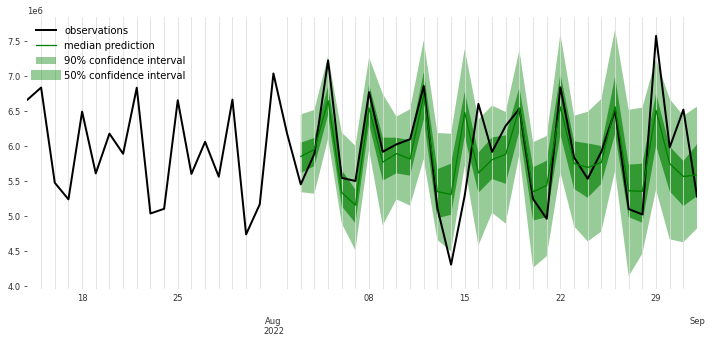

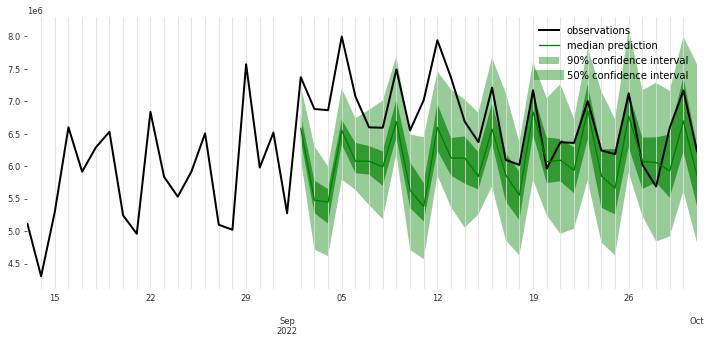

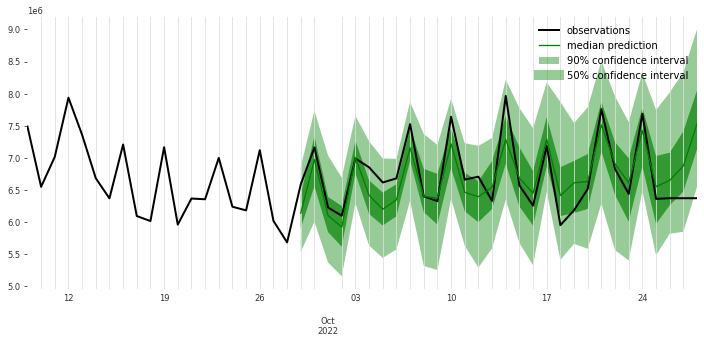

In [138]:
def plot_forecasts(tss, forecasts, past_length, num_plots):
    for target, forecast in islice(zip(tss, forecasts), num_plots):
        ax = target[-past_length:].plot(figsize=(12, 5), linewidth=2)
        forecast.plot(color='g')
        plt.grid(which='both')
        plt.legend(["observations", "median prediction", "90% confidence interval", "50% confidence interval"])
        plt.show()


test_data = ListDataset([
    {'start':revenue_data.index[0], 
     'target':revenue_data.Revenue[:'2022-09-01']
     },
     {'start':revenue_data.index[0], 
     'target':revenue_data.Revenue[:'2022-10-01']
     },
     {'start':revenue_data.index[0], 
     'target':revenue_data.Revenue[:'2022-10-28']
     }], freq = 'D')

forecast_it, ts_it = make_evaluation_predictions(test_data, predictor=model, num_samples=100)

forecasts = list(forecast_it)
tss = list(ts_it)
plot_forecasts(tss, forecasts, past_length=50, num_plots=3)



In [139]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(tss, forecasts)

Running evaluation: 3it [00:00, 43.00it/s]


In [140]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 338181121638.4,
    "abs_error": 39612657.0,
    "abs_target_sum": 581398016.0,
    "abs_target_mean": 6459977.955555555,
    "seasonal_error": 572508.2469299897,
    "MASE": 0.7686525683634015,
    "MAPE": 0.06741726133558484,
    "sMAPE": 0.06941719717449613,
    "MSIS": 6.0553151200719135,
    "QuantileLoss[0.1]": 19139227.600000005,
    "Coverage[0.1]": 0.03333333333333333,
    "QuantileLoss[0.5]": 39612655.5,
    "Coverage[0.5]": 0.35555555555555557,
    "QuantileLoss[0.9]": 23211796.099999998,
    "Coverage[0.9]": 0.8444444444444444,
    "RMSE": 581533.422632268,
    "NRMSE": 0.09002096085051678,
    "ND": 0.06813345747640116,
    "wQuantileLoss[0.1]": 0.03291932045395904,
    "wQuantileLoss[0.5]": 0.068133454896413,
    "wQuantileLoss[0.9]": 0.0399241061393646,
    "mean_absolute_QuantileLoss": 27321226.400000002,
    "mean_wQuantileLoss": 0.04699229382991221,
    "MAE_Coverage": 0.0888888888888889,
    "OWA": NaN
}


In [141]:
metric = pd.DataFrame({'Model':['DeepAREstimator'],
        'RMSE':[int(agg_metrics["RMSE"])],
        'MAPE':[agg_metrics["MAPE"]]})

metrics_df = pd.concat([metrics_df, metric])

In [142]:
revenue_data[-5:]

,Revenue,temperature,humidity,pressure,wind_speed
time,,,,,
2022-10-24,7687252.60,8.895833,0.904583,993.062500,7.041667
2022-10-25,6363573.88,11.208333,0.988750,989.708333,11.375000
2022-10-26,6373218.32,11.208333,0.988750,989.708333,11.375000
2022-10-27,6373218.32,9.895833,0.923333,1000.083333,8.916667
2022-10-28,6373218.32,9.854167,0.980000,999.354167,13.500000


# NN multivariate model (GluonTS library)

In [143]:
# Prepare the training data
training_data = ListDataset([
    {'start':revenue_data.index[0], 
     'target':revenue_data.Revenue[:'2022-08-01'],
     'feat_dynamic_real': [revenue_data.temperature[:'2022-08-01']]
     }], freq = 'D')

In [144]:

estimator = DeepAREstimator(freq="D",
                            prediction_length=30,
                            trainer=Trainer(epochs=10),
                            use_feat_dynamic_real=True)

# use_feat_dynamic_real – Whether to use the feat_dynamic_real field from the data (default: False)

In [145]:
model_5 = estimator.train(training_data=training_data)

100%|██████████| 50/50 [00:06<00:00,  7.15it/s, epoch=10/10, avg_epoch_loss=14.3]


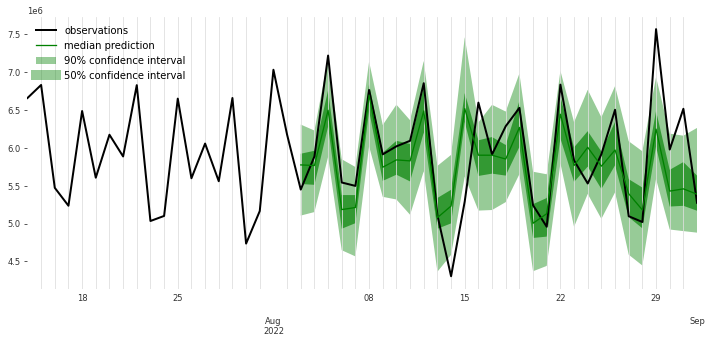

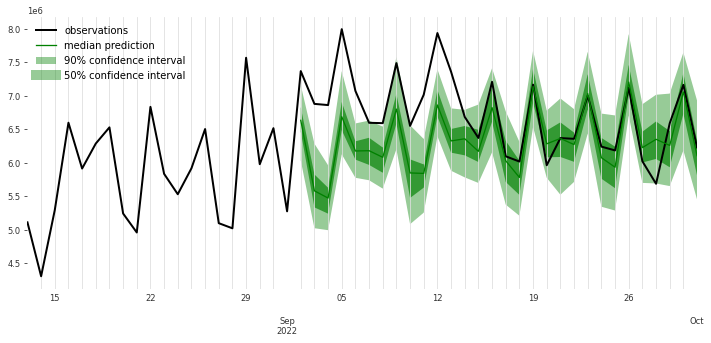

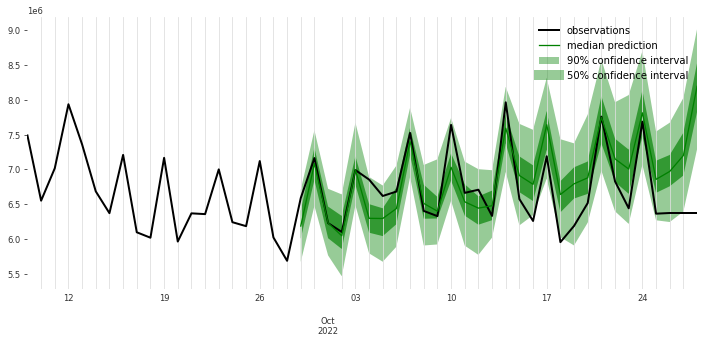

In [146]:
def plot_forecasts(tss, forecasts, past_length, num_plots):
    for target, forecast in islice(zip(tss, forecasts), num_plots):
        ax = target[-past_length:].plot(figsize=(12, 5), linewidth=2)
        forecast.plot(color='g')
        plt.grid(which='both')
        plt.legend(["observations", "median prediction", "90% confidence interval", "50% confidence interval"])
        plt.show()


test_data = ListDataset([
    {'start':revenue_data.index[0], 
     'target':revenue_data.Revenue[:'2022-09-01'],
     'feat_dynamic_real': [revenue_data.temperature[:'2022-09-01']]
     },
     {'start':revenue_data.index[0], 
     'target':revenue_data.Revenue[:'2022-10-01'],
     'feat_dynamic_real': [revenue_data.temperature[:'2022-10-01']]
     },
     {'start':revenue_data.index[0], 
     'target':revenue_data.Revenue[:'2022-10-28'],
     'feat_dynamic_real': [revenue_data.temperature[:'2022-10-28']]
     }], freq = 'D')

forecast_it, ts_it = make_evaluation_predictions(test_data, predictor=model_5, num_samples=100)

forecasts = list(forecast_it)
tss = list(ts_it)
plot_forecasts(tss, forecasts, past_length=50, num_plots=3)



In [147]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(tss, forecasts)

Running evaluation: 3it [00:00, 38.21it/s]


In [148]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 323637640487.8222,
    "abs_error": 38042501.0,
    "abs_target_sum": 581398016.0,
    "abs_target_mean": 6459977.955555555,
    "seasonal_error": 572508.2469299897,
    "MASE": 0.7382947344305256,
    "MAPE": 0.0651380181312561,
    "sMAPE": 0.06590398417578804,
    "MSIS": 6.944292989875504,
    "QuantileLoss[0.1]": 17576430.5,
    "Coverage[0.1]": 0.12222222222222223,
    "QuantileLoss[0.5]": 38042500.5,
    "Coverage[0.5]": 0.3444444444444444,
    "QuantileLoss[0.9]": 23476842.099999998,
    "Coverage[0.9]": 0.7666666666666666,
    "RMSE": 568891.5893980347,
    "NRMSE": 0.08806401404339008,
    "ND": 0.06543280154571425,
    "wQuantileLoss[0.1]": 0.03023132177320674,
    "wQuantileLoss[0.5]": 0.0654328006857182,
    "wQuantileLoss[0.9]": 0.04037998316801961,
    "mean_absolute_QuantileLoss": 26365257.7,
    "mean_wQuantileLoss": 0.045348035208981514,
    "MAE_Coverage": 0.10370370370370374,
    "OWA": NaN
}


In [149]:
metric = pd.DataFrame({'Model':['DeepAREstimator multivariate'],
        'RMSE':[int(agg_metrics["RMSE"])],
        'MAPE':[agg_metrics["MAPE"]]})

metrics_df = pd.concat([metrics_df, metric])

# Results

In [152]:
metrics_df

,Model,RMSE,MAPE
0,ExponentialSmoothing,785315,0.100581
0,LightGBMModel,962769,0.117815
0,NBEATS,564771,0.068024
0,DeepAREstimator,581533,0.067417
0,DeepAREstimator multivariate,568891,0.065138


Models based on the Neural Networks demonstrated better results therefore further development would go towards fine tuning them.

Multivariate model shows improvements, but the difference is too small to be considered reliable. One intersting hypothesis can be made though - perhaps the weather impact should be weighted. A strog wind in summer is not the same as the strong wind in winter. 